# Center Cut Prediction Image

In [1]:
from itertools import groupby, chain
from PIL import Image
import matplotlib.pyplot as plt
import cv2 
import numpy as np
from skimage import io, color
import sys
from skimage import img_as_ubyte
import skimage.io as io
import os
np.set_printoptions(threshold=sys.maxsize)

In [2]:
# !pip install scikit-image

### Commong Utility Functions

In [3]:
def load_image(path, pad=True):
    """
    Load image from a given path and pad it on the sides, so that eash side is divisible by 32 (newtwork requirement)
    
    if pad = True:
        returns image as numpy.array, tuple with padding in pixels as(x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    else:
        returns image as numpy.array
    """
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if not pad:
        return img
    
    height, width, _ = img.shape
    
    if height % 32 == 0:
        y_min_pad = 0
        y_max_pad = 0
    else:
        y_pad = 32 - height % 32
        y_min_pad = int(y_pad / 2)
        y_max_pad = y_pad - y_min_pad
        
    if width % 32 == 0:
        x_min_pad = 0
        x_max_pad = 0
    else:
        x_pad = 32 - width % 32
        x_min_pad = int(x_pad / 2)
        x_max_pad = x_pad - x_min_pad
    
    img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad, x_min_pad, x_max_pad, cv2.BORDER_REFLECT_101)

    return img, (x_min_pad, y_min_pad, x_max_pad, y_max_pad)

In [4]:


# #from utilities.model_errors import ValidationError


# def find_centermost_mask(input_mask, min_pixels):
#     """
#     Take in a binary mask and return a mask of the same shape, with only the centermost contiguous portion.
#     If a mask contains no contours (objects), then just return it (it's all zeros anyway).
#     """

#     # Get all the bits aligned in memory
#     input_mask = np.ascontiguousarray(input_mask, dtype=np.uint8)
#     contours, _ = cv2.findContours(input_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     print('no. of contours : ', len(contours))
    
#     if not contours or len(contours) == 1:
#         return input_mask

#     moments = [cv2.moments(contour) for contour in contours]
#     # (x, y) tuples of centroid locations for contours (that have area > 0)
#     centroids = [
#         (m['m10'] / m['m00'], m['m01'] / m['m00'])
#         if m['m00'] and m['m00'] >= min_pixels else (0, 0)
#         for m in moments
#     ]

#     if not centroids:
#         raise ValidationError(f'No identified footprint contours contain more than {min_pixels} pixels.')

#     # dimensions come 1-indexed, but array indicies are 0-indexed
#     center = [(dim - 1) / 2 for dim in input_mask.shape]

#     # Cacluate (Manhattan) distance from center of image
#     distances_from_center = [abs(x - center[0]) + abs(y - center[1]) for x, y in centroids]
#     centermost_contour = contours[distances_from_center.index(min(distances_from_center))]

#     output_mask = np.zeros(input_mask.shape)
#     cv2.fillPoly(output_mask, centermost_contour.transpose((1, 0, 2)), 1)

#     return output_mask

In [5]:
def find_centermost_mask(input_mask, min_pixels):
    """
    Take in a binary mask and return a mask of the same shape, with only the centermost contiguous portion.
    If a mask contains no contours (objects), then just return it (it's all zeros anyway).
    """

    # Get all the bits aligned in memory
    input_mask = np.ascontiguousarray(input_mask, dtype=np.uint8)
    print(input_mask.shape, np.sum(input_mask))
    contours, _ = cv2.findContours(input_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(len(contours))

    if not contours or len(contours) == 1:
        return input_mask

    moments = [cv2.moments(contour) for contour in contours]
    # (x, y) tuples of centroid locations for contours (that have area > 0)
    centroids = [
        (m['m10'] / m['m00'], m['m01'] / m['m00'])
        if m['m00'] and m['m00'] >= min_pixels else (0, 0)
        for m in moments
    ]

    if not centroids:
        raise ValidationError(f'No identified footprint contours contain more than {min_pixels} pixels.')

    # dimensions come 1-indexed, but array indicies are 0-indexed
    center = [(dim - 1) / 2 for dim in input_mask.shape]

    # Cacluate (Manhattan) distance from center of image
    distances_from_center = [abs(x - center[0]) + abs(y - center[1]) for x, y in centroids]
    centermost_contour = contours[distances_from_center.index(min(distances_from_center))]

    output_mask = np.zeros(input_mask.shape)
    cv2.fillPoly(output_mask, centermost_contour.transpose((1, 0, 2)), 1)

    return output_mask

### Center cut the Prediction Image and Center Cut the Original Image

In [6]:
pred_binary_img_path = '/home/ec2-user/SageMaker/data/footprint/mohan-func-test-run-data/run-1/resnet-50-out'
pred_cc_save_path = '/home/ec2-user/SageMaker/data/footprint/mohan-func-test-run-data/run-1/rn50-cc-analysis'

# pred_binary_img_path = '/home/ec2-user/SageMaker/data/footprint/190-test-images-pred-analysis-rn50-9-jan-2k20/190-test-images-pred-ouput-RGB-rn50-3-jan-2k20'
# pred_cc_save_path = '/home/ec2-user/SageMaker/data/footprint/190-test-images-pred-analysis-rn50-9-jan-2k20/190-test-pred-images-cc'

In [7]:
lst_pred_imgs = [img for img in os.listdir(pred_binary_img_path) if os.path.isfile(os.path.join(pred_binary_img_path, img))]
lst_pred_imgs[:5], len(lst_pred_imgs)

(['image_427_pred_binary.png',
  'image_489_pred_binary.png',
  'image_99_pred_binary.png',
  'image_40_pred_binary.png',
  'image_359_pred_binary.png'],
 627)

In [8]:
def generate_mask(pred_prob, threshold=0.6):
    '''
    generate the mask if the probability is 60%
    '''
    mask = pred_prob[0, :, :, :]
    pred_mask = np.argmax(mask.transpose((1, 2, 0)), axis=-1)
    return pred_mask.astype(np.uint8)

In [9]:
lst_pred_imgs[7:10]

['image_583_pred_binary.png',
 'image_493_pred_binary.png',
 'image_131_pred_binary.png']

In [ ]:
# for idx, pred_img_name in enumerate(lst_pred_imgs[7:10], start=1):
    
#     print('processing : ', idx)
#     pred_img_path_with_filename = os.path.join(pred_binary_img_path, pred_img_name)
#     pred_img = cv2.imread(pred_img_path_with_filename)
#     pred_gray = cv2.cvtColor(pred_img, cv2.COLOR_BGR2GRAY)
#     print(np.unique(pred_gray))
#     plt.imshow(pred_gray)
#     plt.show()
    
# #     pred_gray[pred_gray > 30] = 1
# #     pred_gray[pred_gray < 30] = 0
    
# #----------------------    
#     unique_pixel_values = np.unique(pred_gray)
#     if(len(unique_pixel_values) > 1):  # to handle no building scenario returns one pixel value that is '0'
#         _, thresh = cv2.threshold(pred_gray, unique_pixel_values[0] + 1, 255, 0)
#         print(np.unique(thresh))
#         pred_cc_img_mask=find_centermost_mask(thresh,2000)
#     else:
#         pred_cc_img_mask = np.zeros(pred_gray.shape)
# #     print(np.unique(lbl_cc_img_mask))
# #     print(lbl_cc_img_mask.shape)
# #----------------------    
    
# #     pred_cc_img_mask=find_centermost_mask(pred_gray,10000)
#     print('cc unique', np.unique(pred_cc_img_mask))
# #     print(type(pred_cc_img_mask))
# #     print(pred_cc_img_mask.dtype)
#     pred_cc_img_mask = pred_cc_img_mask.astype(np.byte)
#     pred_cc_img_mask = img_as_ubyte(pred_cc_img_mask)
# #     print(pred_cc_img_mask.dtype)
# #     print(np.unique(pred_cc_img_mask))
#     print('cc shape', pred_cc_img_mask.shape)
#     plt.imshow(pred_cc_img_mask)
#     plt.show()
# #     io.imsave(os.path.join(pred_cc_save_path, pred_img_name.replace('_pred_binary.png', '_pred_cc_binary.tif')), pred_cc_img_mask)
#     print('-' * 30)

### Modified 

In [ ]:
for idx, pred_img_name in enumerate(lst_pred_imgs[7:10], start=1):
    
    print('processing : ', idx)
    pred_img_path_with_filename = os.path.join(pred_binary_img_path, pred_img_name)
    pred_img = cv2.imread(pred_img_path_with_filename)
#     pred_gray = cv2.cvtColor(pred_img, cv2.COLOR_BGR2GRAY)
    pred_gray = io.imread(pred_img, cv2.COLOR_BGR2GRAY)

    print(np.unique(pred_gray))
    plt.imshow(pred_gray)
    plt.show()

#----------------------    
    unique_pixel_values = np.unique(pred_gray)
    if(len(unique_pixel_values) > 1):  # to handle no building scenario returns one pixel value that is '0'
        _, thresh = cv2.threshold(pred_gray, unique_pixel_values[0] + 1, 255, 0)
        print(np.unique(thresh))
        pred_cc_img_mask=find_centermost_mask(thresh,2000)
    else:
        pred_cc_img_mask = np.zeros(pred_gray.shape)
#     print(np.unique(lbl_cc_img_mask))
#     print(lbl_cc_img_mask.shape)
#----------------------    
    
#     pred_cc_img_mask=find_centermost_mask(pred_gray,10000)
    print('cc unique', np.unique(pred_cc_img_mask))
#     print(type(pred_cc_img_mask))
#     print(pred_cc_img_mask.dtype)
    pred_cc_img_mask = pred_cc_img_mask.astype(np.byte)
    pred_cc_img_mask = img_as_ubyte(pred_cc_img_mask)
#     print(pred_cc_img_mask.dtype)
#     print(np.unique(pred_cc_img_mask))
    print('cc shape', pred_cc_img_mask.shape)
    plt.imshow(pred_cc_img_mask)
    plt.show()
#     io.imsave(os.path.join(pred_cc_save_path, pred_img_name.replace('_pred_binary.png', '_pred_cc_binary.tif')), pred_cc_img_mask)
    print('-' * 30)

In [10]:
pred_gray = io.imread('/home/ec2-user/SageMaker/data/footprint/mohan-func-test-run-data/run-1/resnet-50-out/image_493_pred_binary.png')[:, :, 0]

In [11]:
pred_gray.shape

(512, 512)

In [12]:
np.unique(pred_gray)

array([ 68, 253], dtype=uint8)

In [13]:
pred_gray[pred_gray == 68] = 0
pred_gray[pred_gray == 253] = 1

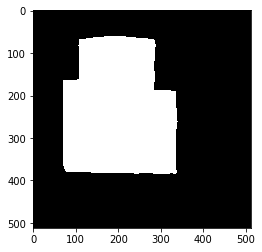

In [14]:
plt.imshow(pred_gray, cmap='gray')

In [ ]:
unique_pixel_values = np.unique(pred_gray)
_, thresh = cv2.threshold(pred_gray, unique_pixel_values[0] + 1, 255, 0)

In [16]:
np.unique(pred_gray)

array([0, 1], dtype=uint8)

In [17]:
center_prop = find_centermost_mask(pred_gray,2000)

(512, 512) 74863
1


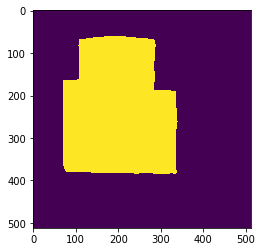

In [18]:
plt.imshow(center_prop)

In [20]:
!ls /home/ec2-user/SageMaker/data/footprint/10009-training-images/input/ | wc -l

10012


In [21]:
! ls /home/ec2-user/SageMaker/data/footprint/10009-training-images/gt-binary/ | wc -l

10009
